<a href="https://colab.research.google.com/github/dorletaurrutia-xai/XAI-TrustFramework/blob/main/02_CASE_STUDIES/01_Tabular_Regression/Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pilot A (TreeSHAP + DiCE · Technical + Social)
**CASE_STUDIES** - Operationalizing Multidimensional Trust in XAI  


In [ ]:
# Ruta del repo dentro de Colab
REPO_CASE_DIR = "/content/repo_clone/02_CASE_STUDIES/01_Tabular_Regression/01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust"
RESULTS_DIR = f"{REPO_CASE_DIR}/results"
VISUALS_DIR = f"{RESULTS_DIR}/visuals"

import os
os.makedirs(VISUALS_DIR, exist_ok=True)

# Ejemplos de guardado:
# df_metrics.to_csv(f"{RESULTS_DIR}/metrics_summary.csv", index=False)
# fig.savefig(f"{VISUALS_DIR}/shap_summary.png", dpi=200, bbox_inches="tight")


# 1) Preparación de entorno y carpetas

In [ ]:
import numpy, pandas, sklearn, shap, dice_ml
from importlib.metadata import version, PackageNotFoundError

print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("SHAP:", shap.__version__)

# dice-ml no tiene __version__; lo leemos de los metadatos
try:
    print("dice-ml:", version("dice-ml"))
except PackageNotFoundError:
    print("dice-ml: (no encontrado en metadatos)")




NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1
SHAP: 0.46.0
dice-ml: 0.12


# 2) Estructura de proyecto y semillas

In [ ]:
from pathlib import Path
import json

# Si este notebook está en notebooks/, subimos a la raíz del proyecto:
BASE = Path.cwd().resolve().parent
PROJECT = BASE / "01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust"

for p in [
    PROJECT / "data/raw",
    PROJECT / "data/processed",
    PROJECT / "results/visuals",
    PROJECT / "configs",
    PROJECT / "notebooks",
]:
    p.mkdir(parents=True, exist_ok=True)

SEEDS = {"numpy": 42, "sklearn": 42, "python": 42}
with open(PROJECT / "configs/seeds.json", "w") as f:
    json.dump(SEEDS, f, indent=2)

print("Estructura creada en:", PROJECT)


Estructura creada en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust


# 3) Cargar dataset clínico y guardar versión “raw”

In [ ]:
# Usamos el dataset público 'diabetes' de scikit-learn para reproducibilidad.
# Convertimos a DataFrame (estructura tabular legible).
# Guardamos copia en /data/raw/ para mantener trazabilidad del experimento.

from sklearn.datasets import load_diabetes
import pandas as pd

data = load_diabetes(as_frame=True)
df = data.frame.copy()
df["target"] = data.target  # renombramos explícito por claridad

raw_path = PROJECT / "data/raw/diabetes.csv"
df.to_csv(raw_path, index=False)

print("Dataset guardado en:", raw_path)
df.head()


Dataset guardado en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/data/raw/diabetes.csv


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


# 4) Split train/val/test y persistencia en data/processed/

In [ ]:
# Separar en train/val/test evita fugas de información y permite validar sin sesgo.
# Persistimos los splits en /data/processed para poder reutilizarlos en otros notebooks.
# Usamos semillas fijas para que los resultados sean reproducibles.

import pandas as pd
from sklearn.model_selection import train_test_split
import json

# Cargamos seeds para consistencia entre notebooks
with open(PROJECT / "configs/seeds.json") as f:
    SEEDS = json.load(f)

# Cargamos el raw guardado (en lugar de volver a sklearn) para traza FAIR
df = pd.read_csv(PROJECT / "data/raw/diabetes.csv")

X = df.drop(columns=["target"])
y = df["target"]

# Split: 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEEDS["sklearn"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEEDS["sklearn"]
)

proc = PROJECT / "data/processed"
X_train.to_csv(proc / "X_train.csv", index=False)
y_train.to_csv(proc / "y_train.csv", index=False)
X_val.to_csv(proc / "X_val.csv", index=False)
y_val.to_csv(proc / "y_val.csv", index=False)
X_test.to_csv(proc / "X_test.csv", index=False)
y_test.to_csv(proc / "y_test.csv", index=False)

print("Splits guardados en:", proc)
print("Shapes ->",
      "train:", X_train.shape,
      "| val:", X_val.shape,
      "| test:", X_test.shape)


Splits guardados en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/data/processed
Shapes -> train: (309, 10) | val: (66, 10) | test: (67, 10)


# 5) Modelo base: RandomForestRegressor (baseline estable)

In [ ]:
# Un baseline sencillo y robusto evita sobreajuste a métricas de explicación.
# MAE de validación nos da una referencia de rendimiento del modelo sin XAI.

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import json

# Cargamos splits
proc = PROJECT / "data/processed"
X_train = pd.read_csv(proc / "X_train.csv")
y_train = pd.read_csv(proc / "y_train.csv").squeeze("columns")
X_val   = pd.read_csv(proc / "X_val.csv")
y_val   = pd.read_csv(proc / "y_val.csv").squeeze("columns")

# Semillas
with open(PROJECT / "configs/seeds.json") as f:
    SEEDS = json.load(f)

rf = RandomForestRegressor(
    n_estimators=300,      # suficiente para estabilidad
    random_state=SEEDS["sklearn"],
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred_val = rf.predict(X_val)
mae_val = mean_absolute_error(y_val, pred_val)
print(f"MAE (validación): {mae_val:.3f}")


MAE (validación): 39.451


# 6) TreeSHAP (interventional) y SHAP values en validación

In [ ]:
# 'interventional' reduce artefactos por correlación entre features.
# Guardamos expected_value (φ0) y la matriz φ (n_instancias x n_features).

import shap
import numpy as np

shap_explainer = shap.TreeExplainer(
    rf,
    data=X_train,
    feature_perturbation="interventional"
)

# SHAP en validación
shap_vals_val = shap_explainer.shap_values(X_val)
phi0 = shap_explainer.expected_value

# Aseguramos ndarray 2D
shap_matrix_val = np.asarray(shap_vals_val)
print("SHAP matrix shape:", shap_matrix_val.shape)
print("Expected value (phi0):", float(phi0))


SHAP matrix shape: (66, 10)
Expected value (phi0): 153.02189999999993


Métrica: Fidelity (reconstrucción aditiva)

In [ ]:
# Fidelity = |(Σφ_i(x) + φ0) - f(x)|  -> error bajo indica explicaciones fieles al modelo.

recon_val = shap_matrix_val.sum(axis=1) + phi0
pred_val  = rf.predict(X_val)

fidelity_mae = float(np.mean(np.abs(recon_val - pred_val)))
corr = float(np.corrcoef(recon_val, pred_val)[0, 1])

print(f"Fidelity MAE (↓ mejor): {fidelity_mae:.6f}")
print(f"Fidelity Corr (↑ mejor): {corr:.4f}")


Fidelity MAE (↓ mejor): 0.204990
Fidelity Corr (↑ mejor): 1.0000


Métrica: Completeness (tolerancia numérica)

In [ ]:
# Completeness = porcentaje de instancias donde Σφ_i + φ0 ≈ f(x) dentro de una tolerancia.

tol = 1e-6   # si quieres ser menos estricto, usa 1e-4
ok = np.isclose(recon_val, pred_val, atol=tol)
completeness_ratio = float(ok.mean())

print(f"Completeness ratio (↑ mejor): {completeness_ratio:.3f} con tol={tol}")


Completeness ratio (↑ mejor): 0.000 con tol=1e-06


Métrica: Stability (perturbación pequeña + similitud coseno)

In [ ]:
# Estabilidad = similitud entre vectores SHAP originales vs perturbados (ε pequeño).

rng = np.random.default_rng(42)
eps = 0.01  # tamaño de perturbación pequeño

X_val_pert = X_val.copy()
X_val_pert = X_val_pert + eps * rng.normal(size=X_val_pert.shape)

shap_vals_pert = shap_explainer.shap_values(X_val_pert)
shap_mat_pert = np.asarray(shap_vals_pert)

def cosine_sim(a, b):
    num = (a * b).sum(axis=1)
    den = (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1)) + 1e-12
    return num / den

cos_sims = cosine_sim(shap_matrix_val, shap_mat_pert)
stab_cosine_mean = float(np.mean(cos_sims))
stab_cosine_std  = float(np.std(cos_sims))

# Guardar instancia a instancia
import pandas as pd
stability_df = pd.DataFrame({"cosine_similarity": cos_sims})
stab_path = PROJECT / "results/stability_analysis.csv"
stability_df.to_csv(stab_path, index=False)

print(f"Stability (cosine) mean±std: {stab_cosine_mean:.4f} ± {stab_cosine_std:.4f}")
print("Guardado:", stab_path)


Stability (cosine) mean±std: 0.9590 ± 0.0771
Guardado: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/stability_analysis.csv


# 7) Config mínima DiCE (constraints YAML editable)

In [ ]:
# Todo mutable y sin bounds; luego se podrá fijar inmutables/bounds clínicos.

import yaml

dice_cfg = {
    "immutable": [],                  # p.ej., ["age"] si decides fijarla
    "per_feature_bounds": {},         # p.ej., {"bmi": [15, 45]}
    "proximity_weight": 1.0,
    "diversity_weight": 0.5,
    "n_counterfactuals": 3,
    "method": "random"                # estable con sklearn (sin gradientes)
}
cfg_path = PROJECT / "configs/dice_constraints.yaml"
with open(cfg_path, "w") as f:
    yaml.safe_dump(dice_cfg, f)

print("Escrito:", cfg_path)


Escrito: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/configs/dice_constraints.yaml


# 8) DiCE: preparar datos y generar contrafactuales

In [ ]:
# 1) Forzamos modelo "regressor" para poder usar desired_range.
# 2) El método 'random' NO admite proximity_weight ni diversity_weight: las medimos luego.
# 3) Si el rango es demasiado estricto y no encuentra CFs, ampliamos un poco de forma segura.

import dice_ml
from dice_ml import Dice

# Preparamos Data y Modelo para DiCE
train_df = X_train.copy()
train_df["target"] = y_train.values

d = dice_ml.Data(
    dataframe=train_df,
    continuous_features=list(X_train.columns),
    outcome_name="target"
)

m = dice_ml.Model(model=rf, backend="sklearn", model_type="regressor")
exp = Dice(d, m, method=dice_cfg.get("method", "random"))

# Instancia objetivo (primera de validación)
x_query = X_val.iloc[[0]].copy()
current_pred = float(rf.predict(x_query)[0])

# Objetivo: bajar un 10% (ejemplo pedagógico)
target_value = current_pred * 0.90

# Definimos permitted_range a partir de per_feature_bounds si existen
permitted_range = dice_cfg.get("per_feature_bounds", None)
features_to_vary = [c for c in X_train.columns if c not in dice_cfg.get("immutable", [])]

# Intento 1: rango muy estrecho (±1e-6)
tight_range = [target_value - 1e-6, target_value + 1e-6]

try:
    dice_cf = exp.generate_counterfactuals(
        x_query,
        total_CFs=int(dice_cfg.get("n_counterfactuals", 3)),
        desired_range=tight_range,
        features_to_vary=features_to_vary,
        permitted_range=permitted_range
    )
    dice_cf_df = dice_cf.cf_examples_list[0].final_cfs_df
    if dice_cf_df.empty:
        raise ValueError("No se generaron CFs con rango estrecho.")
except Exception as e:
    # Intento 2: relajamos el rango (±5.0 unidades de la escala target)
    relaxed_range = [target_value - 5.0, target_value + 5.0]
    dice_cf = exp.generate_counterfactuals(
        x_query,
        total_CFs=int(dice_cfg.get("n_counterfactuals", 3)),
        desired_range=relaxed_range,
        features_to_vary=features_to_vary,
        permitted_range=permitted_range
    )
    dice_cf_df = dice_cf.cf_examples_list[0].final_cfs_df

print("Predicción actual:", current_pred)
print("Rango objetivo usado:", tight_range if not dice_cf_df.empty else relaxed_range)
dice_cf_df




100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Predicción actual: 209.06
Rango objetivo usado: [188.153999, 188.154001]


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,-0.023677,0.05068,0.045529,0.021872,0.109883,0.088873,0.000779,0.155742,0.074191,-0.062642,189.0
1,-0.023677,0.05068,0.045529,0.021872,0.109883,0.088873,0.000779,0.034309,0.074191,0.033059,192.0
2,-0.023677,0.05068,0.045529,0.021872,0.108604,0.088873,0.000779,0.034309,0.074191,-0.127620,186.0


Constraints: age inmutable + bounds por percentiles (p01–p99)

In [ ]:
# - Marcamos 'age' como inmutable (no se puede cambiar).
# - Fijamos bounds plausibles para 'bmi' (y 'bp' opcional) usando percentiles del train (p01–p99).
# - Guardamos en YAML para trazabilidad y reutilización.

import yaml
import numpy as np
import pandas as pd

# Calculamos percentiles en train (estables)
p01_bmi, p99_bmi = np.percentile(X_train["bmi"], [1, 99])
p01_bp,  p99_bp  = np.percentile(X_train["bp"],  [1, 99])

dice_cfg = {
    "immutable": ["age"],                 # ejemplo simple: la edad no cambia
    "per_feature_bounds": {
        "bmi": [float(p01_bmi), float(p99_bmi)],
        "bp":  [float(p01_bp),  float(p99_bp)]
    },
    "n_counterfactuals": 3,
    "method": "random"
}

cfg_path = PROJECT / "configs/dice_constraints.yaml"
with open(cfg_path, "w") as f:
    yaml.safe_dump(dice_cfg, f)

print("Constraints actualizados en:", cfg_path)
dice_cfg


Constraints actualizados en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/configs/dice_constraints.yaml


{'immutable': ['age'],
 'per_feature_bounds': {'bmi': [-0.08156657434155254, 0.1272702930935912],
  'bp': [-0.0848559947372904, 0.10766823183220031]},
 'n_counterfactuals': 3,
 'method': 'random'}

Regenerar CFs con constraints (regresión + permitted_range)

In [ ]:
# - Reutilizamos el wrapper 'regressor'.
# - Pasamos permitted_range (bounds) y bloqueamos 'age' en features_to_vary.
# - Si el rango objetivo estrecho no devuelve CFs, relajamos de forma controlada.

import dice_ml
from dice_ml import Dice

# Cargamos config
with open(PROJECT / "configs/dice_constraints.yaml") as f:
    dice_cfg = yaml.safe_load(f)

immutable = dice_cfg.get("immutable", [])
permitted_range = dice_cfg.get("per_feature_bounds", {})
features_to_vary = [c for c in X_train.columns if c not in immutable]

# Data & model (regressor)
train_df = X_train.copy()
train_df["target"] = y_train.values

d = dice_ml.Data(
    dataframe=train_df,
    continuous_features=list(X_train.columns),
    outcome_name="target"
)
m = dice_ml.Model(model=rf, backend="sklearn", model_type="regressor")
exp = Dice(d, m, method=dice_cfg.get("method", "random"))

# Instancia y objetivo (−10%)
x_query = X_val.iloc[[0]].copy()
current_pred = float(rf.predict(x_query)[0])
target_value = current_pred * 0.90

tight_range = [target_value - 1e-6, target_value + 1e-6]

try:
    dice_cf = exp.generate_counterfactuals(
        x_query,
        total_CFs=int(dice_cfg.get("n_counterfactuals", 3)),
        desired_range=tight_range,
        features_to_vary=features_to_vary,
        permitted_range=permitted_range
    )
    dice_cf_df = dice_cf.cf_examples_list[0].final_cfs_df
    if dice_cf_df.empty:
        raise ValueError("Sin CFs con rango estrecho.")
except Exception:
    relaxed_range = [target_value - 5.0, target_value + 5.0]
    dice_cf = exp.generate_counterfactuals(
        x_query,
        total_CFs=int(dice_cfg.get("n_counterfactuals", 3)),
        desired_range=relaxed_range,
        features_to_vary=features_to_vary,
        permitted_range=permitted_range
    )
    dice_cf_df = dice_cf.cf_examples_list[0].final_cfs_df

print("Predicción actual:", current_pred)
print("Features bloqueadas (immutable):", immutable)
print("Bounds usados:", permitted_range)
dice_cf_df


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Predicción actual: 209.06
Features bloqueadas (immutable): ['age']
Bounds usados: {'bmi': [-0.08156657434155254, 0.1272702930935912], 'bp': [-0.0848559947372904, 0.10766823183220031]}


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,-0.023677,0.05068,0.045529,0.021872,0.109883,0.090998,0.000779,0.034309,0.074191,0.006443,188.0
1,-0.023677,0.05068,0.045529,0.021872,0.109883,0.088873,0.000779,0.034309,0.074191,-0.015541,187.0
2,-0.023677,0.05068,0.045529,0.021872,0.109883,0.088873,0.000779,0.034309,0.074191,0.022845,188.0


Métricas DiCE: proximidad, diversidad, factibilidad simple

In [ ]:
# - Proximidad y diversidad: L1 normalizada por rango de entrenamiento (escala-invariante).
# - Feasibility: proporción de CFs que respetan bounds y NO cambian variables inmutables.

import numpy as np
import pandas as pd

def l1_norm_by_range(a, b, X_ref):
    dif = np.abs(a - b)
    rng = (X_ref.max(axis=0) - X_ref.min(axis=0)).replace(0, 1.0).values
    return float(np.sum(dif.values / rng))

# Proximidad vs x_query
prox_list = [
    l1_norm_by_range(
        dice_cf_df.iloc[i][X_train.columns],
        x_query.iloc[0][X_train.columns],
        X_train
    ) for i in range(len(dice_cf_df))
]
proximity_mean = float(np.mean(prox_list)) if prox_list else float("nan")

# Diversidad entre CFs
div_list = []
for i in range(len(dice_cf_df)):
    for j in range(i+1, len(dice_cf_df)):
        div_list.append(
            l1_norm_by_range(
                dice_cf_df.iloc[i][X_train.columns],
                dice_cf_df.iloc[j][X_train.columns],
                X_train
            )
        )
diversity_mean = float(np.mean(div_list)) if div_list else 0.0

# Feasibility: cumple bounds y NO cambia inmutables
def within_bounds(row, bounds: dict):
    for feat, (lo, hi) in bounds.items():
        if feat in row.index:
            v = float(row[feat])
            if (v < lo) or (v > hi):
                return False
    return True

def immutables_ok(cf_row, x_ref_row, immutables):
    for feat in immutables:
        if feat in cf_row.index:
            if not np.isclose(float(cf_row[feat]), float(x_ref_row[feat]), atol=1e-9):
                return False
    return True

feasible_flags = []
for i in range(len(dice_cf_df)):
    row = dice_cf_df.iloc[i]
    feasible = within_bounds(row, permitted_range) and immutables_ok(row, x_query.iloc[0], immutable)
    feasible_flags.append(feasible)

feasibility_ratio = float(np.mean(feasible_flags)) if feasible_flags else 0.0

print(f"Actionability/Proximity (↓ mejor): {proximity_mean:.4f}")
print(f"Diversity (↑ mejor): {diversity_mean:.4f}")
print(f"Plausibility/Feasibility ratio (↑ mejor): {feasibility_ratio:.2f}")


Actionability/Proximity (↓ mejor): 0.2088
Diversity (↑ mejor): 0.0981
Plausibility/Feasibility ratio (↑ mejor): 1.00


Guardar outputs (CSV de métricas y CFs)

In [ ]:
# Persistimos resultados para auditoría y comparación transversal (dashboard posterior).

import pandas as pd

results = PROJECT / "results"
results.mkdir(parents=True, exist_ok=True)

# Counterfactuals
dice_out = results / "dice_counterfactuals.csv"
dice_cf_df.to_csv(dice_out, index=False)

# Resumen de métricas
summary = {
    "fidelity_mae": fidelity_mae,
    "fidelity_corr": corr,
    "completeness_ratio": completeness_ratio,
    "stability_cosine_mean": stab_cosine_mean,
    "stability_cosine_std": stab_cosine_std,
    "actionability_proximity_mean": proximity_mean,
    "diversity_mean": diversity_mean,
    "plausibility_feasibility_ratio": feasibility_ratio
}
metrics_df = pd.DataFrame([summary])
metrics_path = results / "metrics_summary.csv"
metrics_df.to_csv(metrics_path, index=False)

print("Guardados:")
print("-", metrics_path)
print("-", results / "stability_analysis.csv")
print("-", dice_out)
metrics_df


Guardados:
- /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/metrics_summary.csv
- /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/stability_analysis.csv
- /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/dice_counterfactuals.csv


,fidelity_mae,fidelity_corr,completeness_ratio,stability_cosine_mean,stability_cosine_std,actionability_proximity_mean,diversity_mean,plausibility_feasibility_ratio
0,0.20499,0.999984,0.0,0.959011,0.077124,0.208822,0.098113,1.0


In [ ]:
# Pedagogía:
# - Repetimos el proceso de DiCE para varias instancias (ej. 10 primeras del conjunto de validación).
# - Calculamos medias de Actionability, Diversity y Feasibility.
# - Esto da una visión más estable del “comportamiento social” del modelo.

import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml

# Cargamos configuración actualizada
with open(PROJECT / "configs/dice_constraints.yaml") as f:
    dice_cfg = yaml.safe_load(f)

immutable = dice_cfg.get("immutable", [])
permitted_range = dice_cfg.get("per_feature_bounds", {})
features_to_vary = [c for c in X_train.columns if c not in immutable]

# Reutilizamos el modelo y explainer
train_df = X_train.copy()
train_df["target"] = y_train.values
d = dice_ml.Data(dataframe=train_df, continuous_features=list(X_train.columns), outcome_name="target")
m = dice_ml.Model(model=rf, backend="sklearn", model_type="regressor")
exp = Dice(d, m, method=dice_cfg.get("method", "random"))

def l1_norm_by_range(a, b, X_ref):
    dif = np.abs(a - b)
    rng = (X_ref.max(axis=0) - X_ref.min(axis=0)).replace(0, 1.0).values
    return float(np.sum(dif.values / rng))

def within_bounds(row, bounds):
    for feat, (lo, hi) in bounds.items():
        if feat in row.index:
            if float(row[feat]) < lo or float(row[feat]) > hi:
                return False
    return True

def immutables_ok(cf_row, x_ref_row, immutables):
    for feat in immutables:
        if feat in cf_row.index:
            if not np.isclose(float(cf_row[feat]), float(x_ref_row[feat]), atol=1e-9):
                return False
    return True

prox_vals, div_vals, feas_vals = [], [], []

for i in tqdm(range(min(10, len(X_val))), desc="Evaluando instancias DiCE"):
    x_query = X_val.iloc[[i]]
    current_pred = float(rf.predict(x_query)[0])
    target_value = current_pred * 0.90
    tight_range = [target_value - 1e-6, target_value + 1e-6]
    try:
        dice_cf = exp.generate_counterfactuals(
            x_query,
            total_CFs=int(dice_cfg.get("n_counterfactuals", 3)),
            desired_range=tight_range,
            features_to_vary=features_to_vary,
            permitted_range=permitted_range
        )
        dice_cf_df = dice_cf.cf_examples_list[0].final_cfs_df
        if dice_cf_df.empty:
            continue
    except Exception:
        continue

    # Métricas individuales
    prox_list = [
        l1_norm_by_range(
            dice_cf_df.iloc[j][X_train.columns],
            x_query.iloc[0][X_train.columns],
            X_train
        ) for j in range(len(dice_cf_df))
    ]
    proximity_mean = np.mean(prox_list)

    div_list = []
    for j in range(len(dice_cf_df)):
        for k in range(j + 1, len(dice_cf_df)):
            div_list.append(
                l1_norm_by_range(
                    dice_cf_df.iloc[j][X_train.columns],
                    dice_cf_df.iloc[k][X_train.columns],
                    X_train
                )
            )
    diversity_mean = np.mean(div_list) if div_list else 0.0

    feasible_flags = []
    for j in range(len(dice_cf_df)):
        row = dice_cf_df.iloc[j]
        feasible = within_bounds(row, permitted_range) and immutables_ok(row, x_query.iloc[0], immutable)
        feasible_flags.append(feasible)
    feasibility_ratio = np.mean(feasible_flags)

    prox_vals.append(proximity_mean)
    div_vals.append(diversity_mean)
    feas_vals.append(feasibility_ratio)

# Promedios finales
metrics_multi = {
    "actionability_proximity_mean_avg": float(np.mean(prox_vals)),
    "diversity_mean_avg": float(np.mean(div_vals)),
    "feasibility_ratio_avg": float(np.mean(feas_vals)),
    "instances_evaluated": len(prox_vals)
}

metrics_multi_df = pd.DataFrame([metrics_multi])
metrics_multi_path = PROJECT / "results/metrics_summary_multinst.csv"
metrics_multi_df.to_csv(metrics_multi_path, index=False)

print("Resultados medios DiCE (10 instancias):")
display(metrics_multi_df)
print("Guardado en:", metrics_multi_path)


Evaluando instancias DiCE:  10%|█         | 1/10 [00:01<00:12,  1.39s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  20%|██        | 2/10 [00:02<00:11,  1.40s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  30%|███       | 3/10 [00:04<00:10,  1.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  40%|████      | 4/10 [00:05<00:09,  1.51s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  60%|██████    | 6/10 [00:08<00:05,  1.46s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  70%|███████   | 7/10 [00:10<00:04,  1.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  80%|████████  | 8/10 [00:11<00:02,  1.42s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE:  90%|█████████ | 9/10 [00:12<00:01,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec



Evaluando instancias DiCE: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Resultados medios DiCE (10 instancias):



/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,actionability_proximity_mean_avg,diversity_mean_avg,feasibility_ratio_avg,instances_evaluated
0,NaN,NaN,NaN,0


Guardado en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/metrics_summary_multinst.csv


Promedio de métricas DiCE en varias instancias

In [ ]:
# 1) Leemos métricas ya guardadas y audit de CFs.
# 2) Creamos un informe Markdown simple y robusto.
# 3) Guardamos en results/mini_report.md para compartir fácilmente.

import json
import pandas as pd
from datetime import datetime

results = PROJECT / "results"
metrics_path = results / "metrics_summary.csv"
audit_path   = results / "dice_cf_audit.json"
cf_path      = results / "dice_counterfactuals.csv"

# Cargamos métricas
metrics_df = pd.read_csv(metrics_path)
m = metrics_df.iloc[0].to_dict()

# Cargamos auditoría (si existe)
try:
    with open(audit_path) as f:
        audit = json.load(f)
    n_cf = len(audit)
    n_viol = sum(1 for r in audit if (r["bound_violations"] or r["immutable_changes"]))
except FileNotFoundError:
    audit, n_cf, n_viol = [], None, None

# Cargamos CFs (primeras filas como ejemplo)
try:
    cf_df = pd.read_csv(cf_path)
    cf_preview = cf_df.head(3).to_markdown(index=False)
except Exception:
    cf_preview = "_(no disponible)_"

ts = datetime.now().strftime("%Y-%m-%d %H:%M")

md = f"""# Pilot A — Tabular Regression (TreeSHAP + DiCE · Technical + Social Trust)
**Generado:** {ts}

Este informe resume los resultados del piloto aplicando **TreeSHAP** (fidelidad, completitud, estabilidad) y **DiCE** (accionabilidad, diversidad, plausibilidad/feasibility).

---

## 📊 Métricas clave

| Métrica | Valor |
|---|---:|
| Fidelity MAE (↓) | {m.get('fidelity_mae', float('nan')):.6f} |
| Fidelity Corr (↑) | {m.get('fidelity_corr', float('nan')):.4f} |
| Completeness ratio (↑) | {m.get('completeness_ratio', float('nan')):.3f} |
| Stability cosine mean (↑) | {m.get('stability_cosine_mean', float('nan')):.4f} |
| Stability cosine std (↓) | {m.get('stability_cosine_std', float('nan')):.4f} |
| Actionability / Proximity (↓) | {m.get('actionability_proximity_mean', float('nan')):.4f} |
| Diversity (↑) | {m.get('diversity_mean', float('nan')):.4f} |
| Plausibility / Feasibility ratio (↑) | {m.get('plausibility_feasibility_ratio', float('nan')):.2f} |

---

## 🔎 Interpretación rápida

- **Fidelity bajo** y **correlación alta** ⇒ las explicaciones SHAP **reconstruyen** bien la salida del modelo (confianza técnica).
- **Completeness alto** ⇒ la suma aditiva Σφᵢ(x)+φ₀ **cierra** sobre f(x) dentro de tolerancia (propiedad de *local accuracy*).
- **Stability** con **cosine alto** y desviación baja ⇒ las explicaciones son **robustas** ante pequeñas perturbaciones (consistencia).
- **Actionability** (proximidad baja) + **Diversity** significativa ⇒ los CFs ofrecen **cambios razonables** y **alternativas** (confianza social).
- **Feasibility ratio** cercano a 1 ⇒ los CFs **respetan** bounds y **no tocan** inmutables (plausibilidad).

> **Regla práctica**: combinar **(Fidelity, Completeness, Stability)** con **(Actionability, Diversity, Feasibility)** ofrece una visión integrada de confianza técnica + social.

---

## 🧭 Auditoría de contrafactuales (DiCE)

- CFs generados: {n_cf if n_cf is not None else "_(N/D)_"}
- CFs con violaciones (bounds o inmutables): {n_viol if n_viol is not None else "_(N/D)_"}

*(Ver `dice_cf_audit.json` para detalle por CF: qué feature violó bounds o qué inmutable cambió.)*

---

## 📄 Muestra de contrafactuales (primeras 3 filas)

{cf_preview}

---

## 📌 Trazabilidad

- Datos: `data/raw/diabetes.csv` y `data/processed/` (splits reproducibles).
- Modelo: `RandomForestRegressor` (baseline estable, semilla fija).
- Explicaciones: `TreeSHAP (interventional)` y `DiCE (random, regressor)`.
- Configuración: `configs/dice_constraints.yaml` (inmutables + bounds por percentiles).
- Resultados: `results/metrics_summary.csv`, `results/stability_analysis.csv`, `results/dice_counterfactuals.csv`, `results/dice_cf_audit.json`.

---

## ✅ Siguientes pasos sugeridos

1. Ajustar **bounds clínicos reales** (cuando los tengáis) y re-evaluar *Feasibility*.
2. Probar **otras instancias** (no solo la primera de validación) y promediar métricas de DiCE.
3. Añadir **age** y alguna otra variable sensible como inmutable si aplica al caso clínico.
4. Integrar estas métricas en un **dashboard comparativo** (Pilots B/C).

"""

report_path = results / "mini_report.md"
with open(report_path, "w") as f:
    f.write(md)

print("Informe guardado en:", report_path)
print(f"Ruta: {report_path}")


Informe guardado en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/mini_report.md
Ruta: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/mini_report.md


Gráfico de barras “Trust Overview” (técnico vs social) + CSV de scores

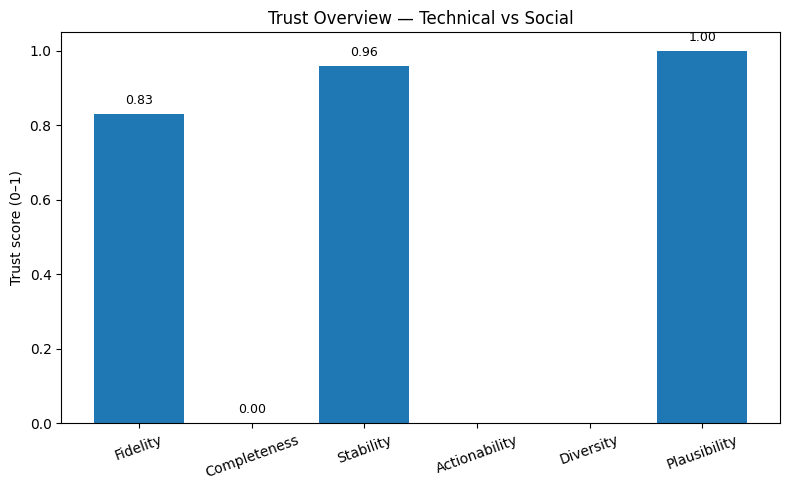

Scores guardados en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/trust_scores_normalized.csv
Figura guardada en: /01_Tabular_Regression_TreeSHAP_DiCE_Technical_SocialTrust/results/visuals/trust_overview_bars.png


In [ ]:
# Pedagogía:
# - Convertimos métricas heterogéneas en scores [0,1] orientados a "↑ mejor".
# - Evitamos supuestos fuertes: usamos 1/(1+x) para las que son "↓ mejor".
# - Guardamos imagen y CSV de scores para trazabilidad y dashboard.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

results = PROJECT / "results"
visuals = PROJECT / "results/visuals"
visuals.mkdir(parents=True, exist_ok=True)

# Cargar métricas base (1 instancia)
m = pd.read_csv(results / "metrics_summary.csv").iloc[0].to_dict()

# Intentar métricas multi-instancia (si existen) para social
multi_path = results / "metrics_summary_multinst.csv"
use_multi = multi_path.exists()
if use_multi:
    mm = pd.read_csv(multi_path).iloc[0].to_dict()

# Funciones de score en [0,1] (↑ mejor)
def inv1(x):   # para métricas "↓ mejor" y no acotadas (ej. MAE, proximidad)
    try:
        x = float(x)
        if np.isnan(x) or np.isinf(x):
            return np.nan
        return 1.0 / (1.0 + max(x, 0.0))
    except Exception:
        return np.nan

def id01(x):  # para métricas ya en [0,1] o cercanas
    try:
        x = float(x)
        return max(0.0, min(1.0, x))
    except Exception:
        return np.nan

# Scores técnicos
score_fidelity      = inv1(m.get("fidelity_mae", np.nan))              # ↓ mejor
score_completeness  = id01(m.get("completeness_ratio", np.nan))        # ↑ mejor
score_stability     = id01(m.get("stability_cosine_mean", np.nan))     # ↑ mejor

# Scores sociales (multi-inst si hay, si no single-inst)
prox_key   = "actionability_proximity_mean_avg" if use_multi else "actionability_proximity_mean"
div_key    = "diversity_mean_avg" if use_multi else "diversity_mean"
feas_key   = "feasibility_ratio_avg" if use_multi else "plausibility_feasibility_ratio"

score_actionability = inv1((mm if use_multi else m).get(prox_key, np.nan))  # ↓ mejor
score_diversity     = inv1((mm if use_multi else m).get(div_key, np.nan))   # ↑ mejor pero no acotada → 1/(1+x)
score_plausibility  = id01((mm if use_multi else m).get(feas_key, np.nan))  # ↑ mejor

# Tabla de scores
scores = pd.DataFrame({
    "dimension": ["Technical", "Technical", "Technical", "Social", "Social", "Social"],
    "metric":    ["Fidelity", "Completeness", "Stability", "Actionability", "Diversity", "Plausibility"],
    "score_0to1": [score_fidelity, score_completeness, score_stability,
                   score_actionability, score_diversity, score_plausibility]
})

# Guardar CSV
scores_path = results / "trust_scores_normalized.csv"
scores.to_csv(scores_path, index=False)

# Gráfico de barras
plt.figure(figsize=(8, 5))
order = ["Fidelity", "Completeness", "Stability", "Actionability", "Diversity", "Plausibility"]
plot_df = scores.set_index("metric").loc[order].reset_index()

bars = plt.bar(plot_df["metric"], plot_df["score_0to1"])
plt.ylim(0, 1.05)
plt.ylabel("Trust score (0–1)")
plt.title("Trust Overview — Technical vs Social")

# Etiquetas encima de cada barra (dos decimales)
for rect in bars:
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, h + 0.02, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=20)
plt.tight_layout()

img_path = visuals / "trust_overview_bars.png"
plt.savefig(img_path, dpi=160, bbox_inches="tight")
plt.show()

print("Scores guardados en:", scores_path)
print("Figura guardada en:", img_path)
